# **Downloading Dataset**

In [ ]:
%%capture

def kaggleSetUp():
  !pip install kaggle
  from google.colab import drive
  drive.mount('/content/drive')
  !mkdir  ~/.kaggle
  !cp /content/drive/MyDrive/Kaggle/Kaggle_Credential/kaggle.json ~/.kaggle/kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle config --list


kaggleSetUp()
!kaggle datasets download paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

In [ ]:
%%capture
!pip install tensorflow
!pip install keras
!pip install --upgrade tensorflow
!pip install keras-preprocessing

# **Importing Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers, models

from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input


import os
import numpy as np
import matplotlib.pyplot as plt

import warnings




# **Data Exploration**

In [ ]:
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"
val_dir = "//content/chest_xray/val"

In [ ]:
print(os.listdir(train_dir))
print(os.listdir(test_dir))
print(os.listdir(val_dir))

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


In [ ]:
os.listdir(train_dir)[0]


'NORMAL'

In [ ]:
labels = ["PNEUMONIA","NORMAL"]
labels

['PNEUMONIA', 'NORMAL']

In [ ]:
image_size = (256, 256)
batch_size = 32

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
    validation_split=0.2,
    subset='training',
    seed=27
)

val_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary',
    validation_split=0.2,
    subset='validation',
    seed=27
)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='binary'
)


Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


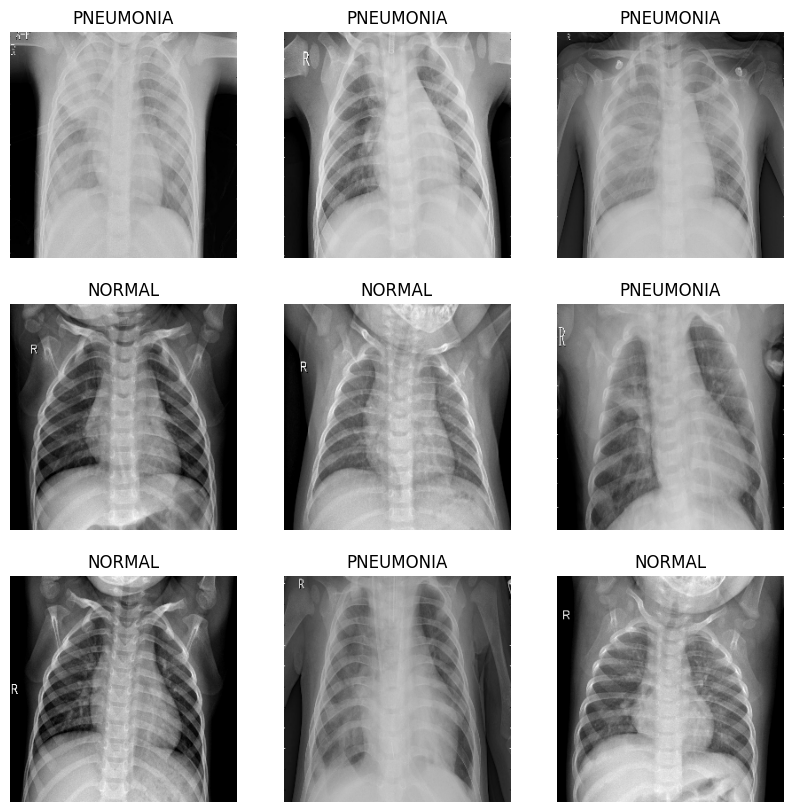

In [ ]:

class_names = train_data.class_names


plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

<ipython-input-10-489c529904bf>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_count[int(label)] += 1


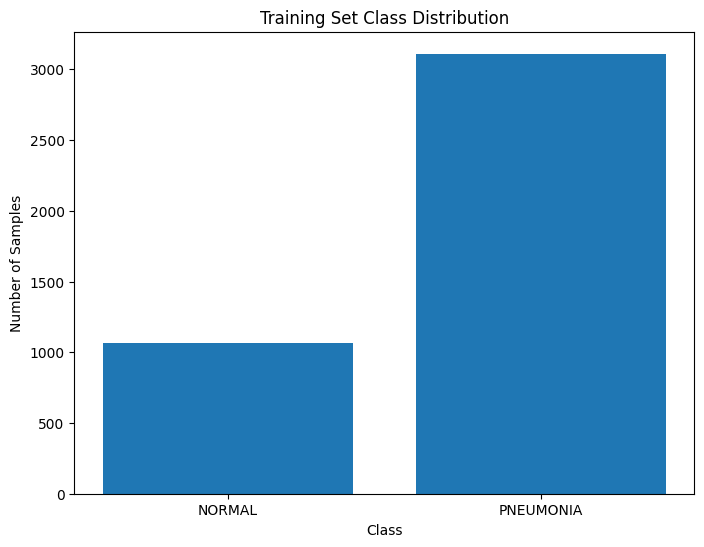

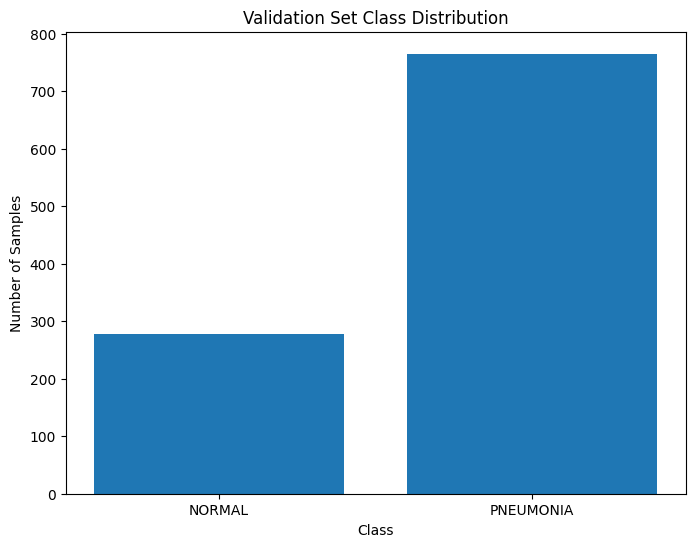

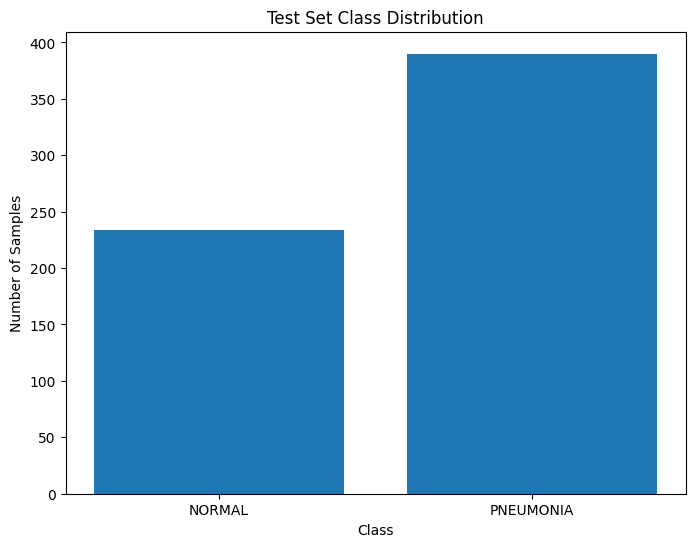

In [ ]:

def plot_class_distribution(dataset, class_names, dataset_name='Dataset'):
    class_count = np.zeros(len(class_names))


    for _, labels in dataset:
        labels = labels.numpy()
        for label in labels:
            class_count[int(label)] += 1


    plt.figure(figsize=(8, 6))
    plt.bar(class_names, class_count)
    plt.title(f'{dataset_name} Class Distribution')
    plt.ylabel('Number of Samples')
    plt.xlabel('Class')
    plt.show()


plot_class_distribution(train_data, class_names, dataset_name='Training Set')
plot_class_distribution(val_data, class_names, dataset_name='Validation Set')
plot_class_distribution(test_data, class_names, dataset_name='Test Set')

# **Data Augmentation**

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential


data_augmentation = Sequential([
    layers.RandomRotation(factor=0.05),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomContrast(factor=0.1),
    layers.Resizing(256, 256)
])



In [ ]:

train_data_augmented = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))

train_data_augmented = train_data_augmented.prefetch(buffer_size=AUTOTUNE)


val_data_prefetched = val_data.prefetch(buffer_size=AUTOTUNE)
test_data_prefetched = test_data.prefetch(buffer_size=AUTOTUNE)

In [ ]:

def plot_augmented_examples(dataset, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()

        for i in range(min(num_images, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].astype("uint8"))
            plt.axis("off")
    plt.show()

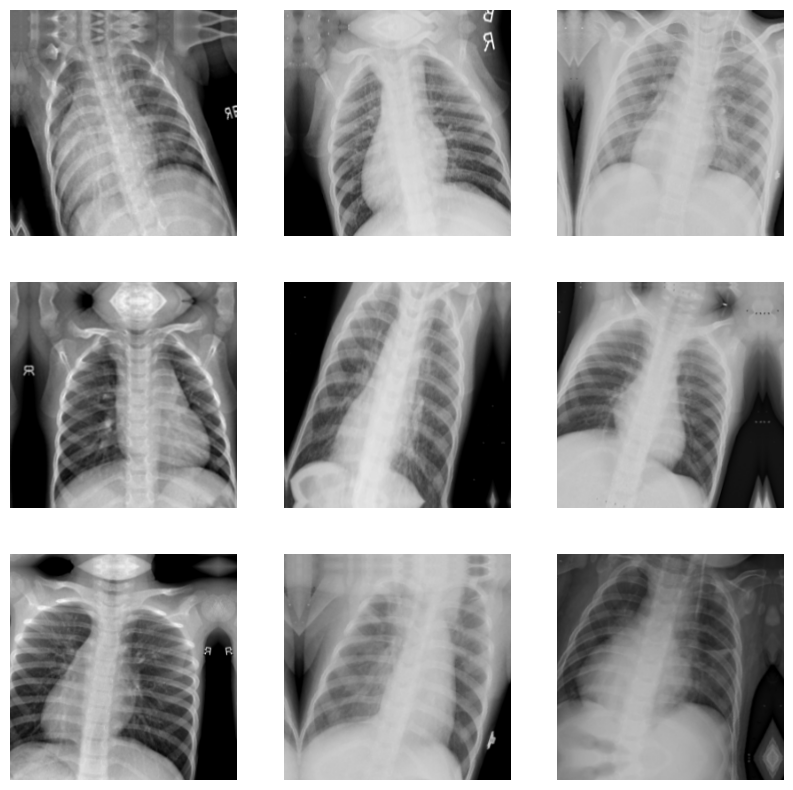

In [ ]:
plot_augmented_examples(train_data_augmented)

# **Data Preprocessing**

In [ ]:
def preprocess_vgg(image, label):
    image = vgg_preprocess_input(image)
    return image, label

def preprocess_resnet(image, label):
    image = resnet_preprocess_input(image)
    return image, label

def preprocess_pneumonia_net(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [ ]:

train_data_vgg = train_data_augmented.map(preprocess_vgg)
val_data_vgg = val_data.map(preprocess_vgg)
test_data_vgg = test_data.map(preprocess_vgg)


train_data_resnet = train_data_augmented.map(preprocess_resnet)
val_data_resnet = val_data.map(preprocess_resnet)
test_data_resnet = test_data.map(preprocess_resnet)

train_data_pneumonia = train_data_augmented.map(preprocess_pneumonia_net)
val_data_pneumonia = val_data.map(preprocess_pneumonia_net)
test_data_pneumonia = test_data.map(preprocess_pneumonia_net)


# **Baseline Models Testing**

# **VGG16**

In [ ]:
def create_vgg16_model(input_shape=(256, 256, 3)):
    base_model_vgg = VGG16(weights='imagenet',
                           include_top=False,
                           input_shape=input_shape)


    base_model_vgg.trainable = False
    inputs = layers.Input(shape=input_shape)
    x = base_model_vgg(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1)(x)
    model_vgg = Model(inputs, outputs)
    model_vgg.compile(optimizer=Adam(learning_rate = 1e-3),
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=[
                        'accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')
                    ])

    return model_vgg

In [ ]:
def train_and_evaluate(model, train_dataset, val_dataset, epochs=5):

    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        verbose=1)

    return history

# **Training VGG16**

In [ ]:
model_vgg = create_vgg16_model()
history_vgg = train_and_evaluate(model_vgg, train_data_vgg, val_data_vgg)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.6087 - loss: 0.9230 - precision: 0.7625 - recall: 0.6655 - val_accuracy: 0.8667 - val_loss: 0.2812 - val_precision: 0.9786 - val_recall: 0.8366
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.8931 - loss: 0.2605 - precision: 0.9408 - recall: 0.9128 - val_accuracy: 0.9166 - val_loss: 0.1963 - val_precision: 0.9721 - val_recall: 0.9124
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9204 - loss: 0.1990 - precision: 0.9569 - recall: 0.9348 - val_accuracy: 0.9032 - val_loss: 0.2091 - val_precision: 0.9854 - val_recall: 0.8810
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9231 - loss: 0.1887 - precision: 0.9598 - recall: 0.9368 - val_accuracy: 0.9233 - val_loss: 0.1718 - val_precision: 0.9831 - val_recall: 0.9111
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9301 - loss: 0.1698 - precision: 0.9635 - r

In [ ]:
def plot_history(history, title):
    plt.figure(figsize=(18, 12))
    plt.subplot(2, 2, 1)
    plt.plot(history.history.get('accuracy', []), label='Train Accuracy')
    plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(2, 2, 2)
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.subplot(2, 2, 3)
    plt.plot(history.history.get('precision', []), label='Train Precision')
    plt.plot(history.history.get('val_precision', []), label='Validation Precision')
    plt.title(f'{title} Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()


    plt.subplot(2, 2, 4)
    plt.plot(history.history.get('recall', []), label='Train Recall')
    plt.plot(history.history.get('val_recall', []), label='Validation Recall')
    plt.title(f'{title} Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

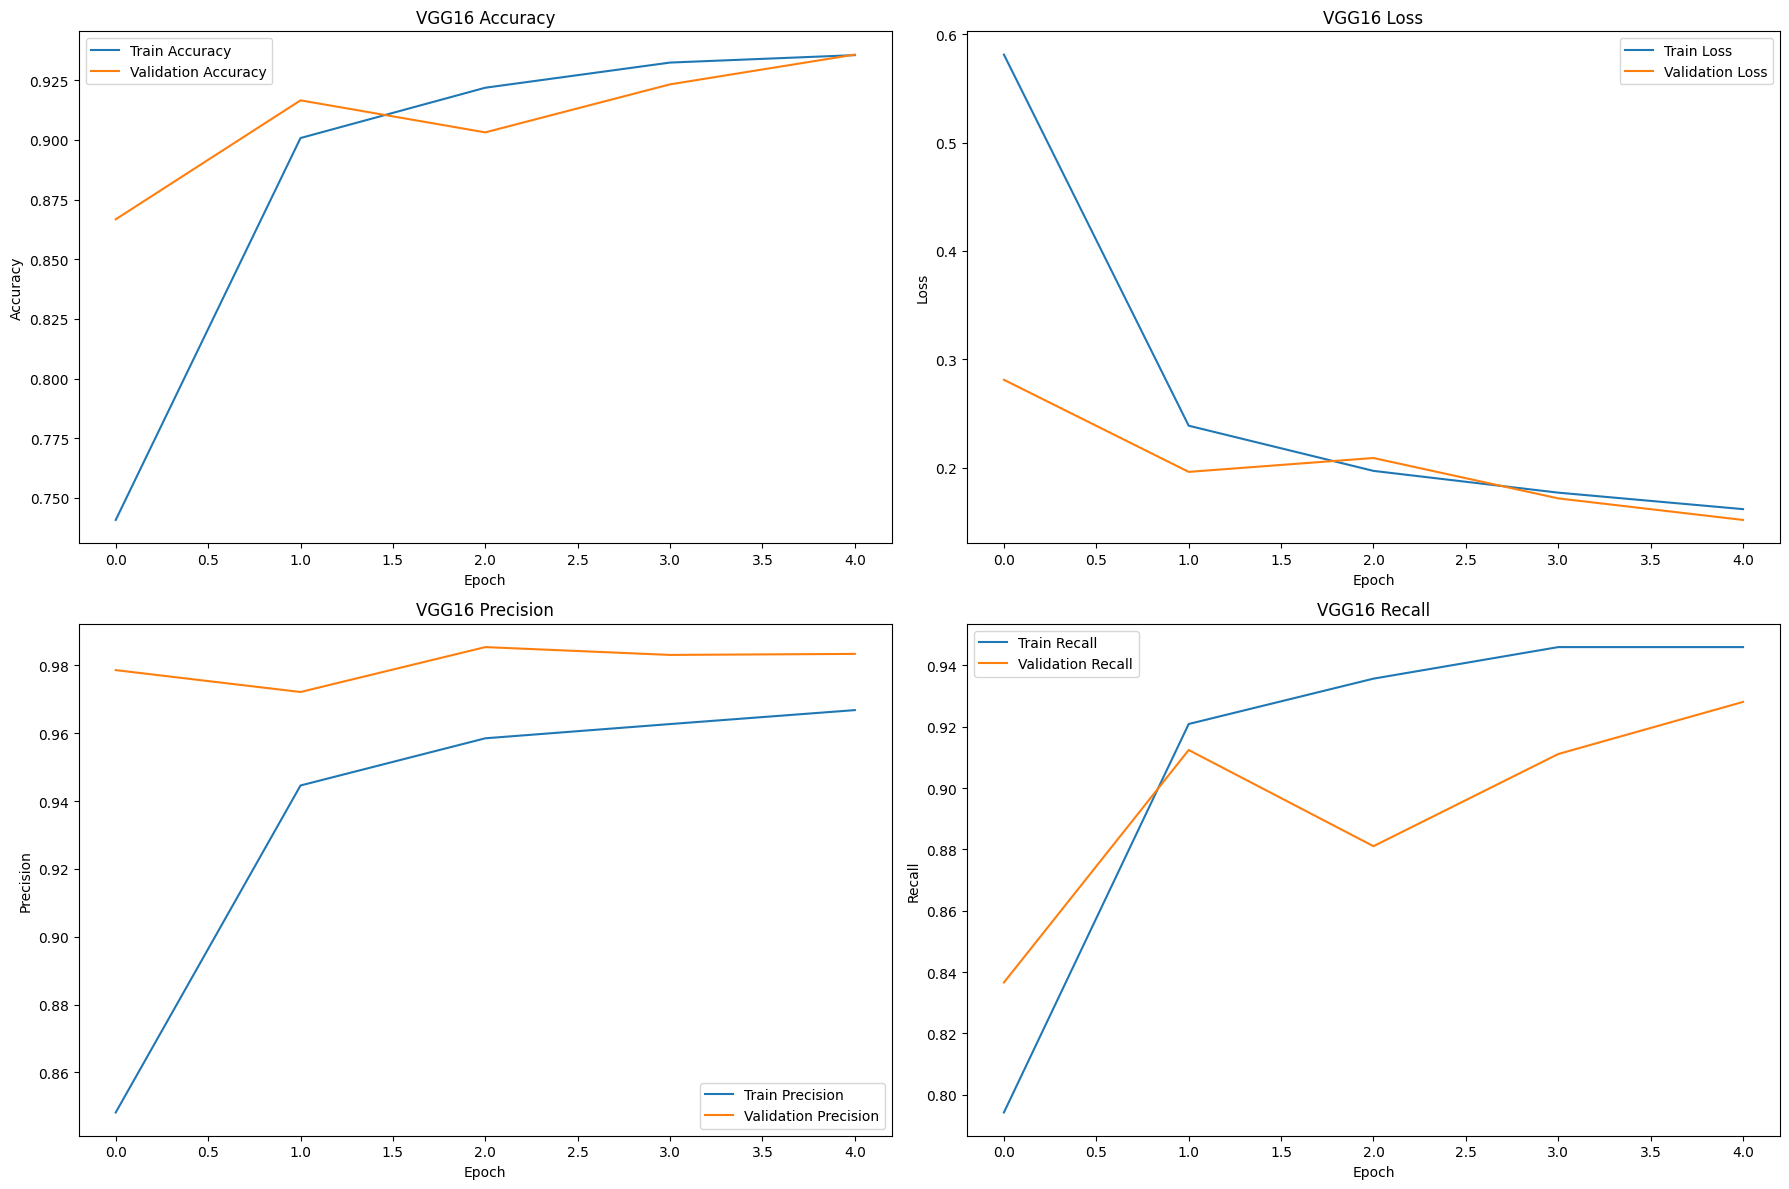

In [ ]:
plot_history(history_vgg, 'VGG16')

In [ ]:
def evaluate_model(model, dataset, specified_set):

    dataset_loss, dataset_accuracy, dataset_precision, dataset_recall = model.evaluate(dataset, verbose=0)


    print(f"{specified_set} Loss: {dataset_loss}")
    print(f"{specified_set} Accuracy: {dataset_accuracy}")
    print(f"{specified_set} Precision: {dataset_precision}")
    print(f"{specified_set} Recall: {dataset_recall}")

In [ ]:
evaluate_model(model_vgg, train_data_vgg, 'Train')

Train Loss: 0.14801949262619019
Train Accuracy: 0.9441648721694946
Train Precision: 0.9662885069847107
Train Recall: 0.9585208892822266


In [ ]:
evaluate_model(model_vgg, val_data_vgg, 'Validation')

Validation Loss: 0.15193608403205872
Validation Accuracy: 0.9357622265815735
Validation Precision: 0.9833794832229614
Validation Recall: 0.9281045794487


In [ ]:
model_vgg.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,716,229 (56.14 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,028 (4.02 KB)

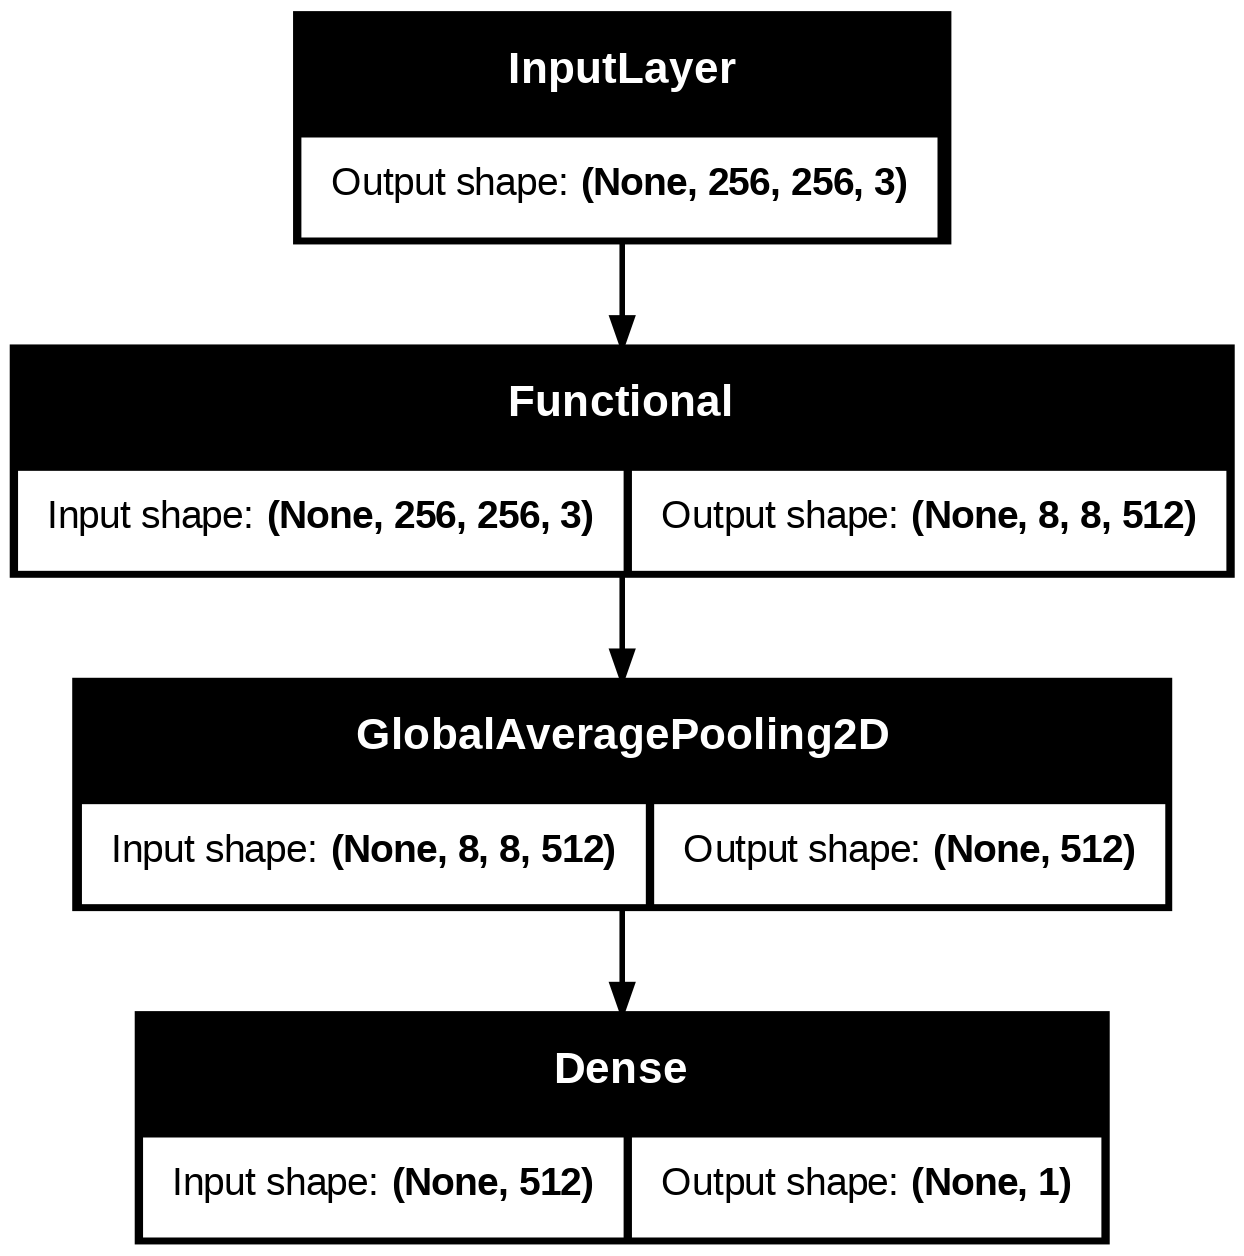

In [ ]:
tf.keras.utils.plot_model(model_vgg, show_shapes=True)

In [ ]:
from tensorflow.keras.models import load_model

model_vgg.save('/content/drive/MyDrive/SAVED MODELS/model_vgg.h5')


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/SAVED MODELS/model_vgg.h5")

In [ ]:
from keras.preprocessing import image
import numpy as np
from keras.applications.vgg16 import preprocess_input
from keras.activations import sigmoid

def predict_pneumonia(model, img_path, target_size=(256, 256)):

    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    img_data = preprocess_input(x)


    classes = model.predict(img_data)
    probability = sigmoid(classes[0][0])


    prediction = 1 if probability > 0.5 else 0


    print(f"Predicted Probability: {probability}")
    print(f"Predicted Class: {prediction}")

    return probability, prediction


In [ ]:
img_path = "/content/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
probability, prediction = predict_pneumonia(model_vgg, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Probability: 0.018132852390408516
Predicted Class: 0


**RGG50**

In [ ]:
def create_resnet50_model(input_shape=(256, 256, 3)):
    base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model_resnet.trainable = False
    inputs = layers.Input(shape=input_shape)
    x = base_model_resnet(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1)(x)
    model_resnet = Model(inputs, outputs)
    model_resnet.compile(optimizer=Adam(learning_rate = 1e-3),
                         loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                         metrics=[
                            'accuracy',
                            tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.Recall(name='recall')
                         ])

    return model_resnet


# **Training ResNet50**

In [ ]:
model_resnet = create_resnet50_model()
history_resnet = train_and_evaluate(model_resnet, train_data_resnet, val_data_resnet)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8214 - loss: 0.3552 - precision: 0.8967 - recall: 0.8576 - val_accuracy: 0.9358 - val_loss: 0.1600 - val_precision: 0.9629 - val_recall: 0.9490
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 180s 979ms/step - accuracy: 0.9411 - loss: 0.1564 - precision: 0.9752 - recall: 0.9448 - val_accuracy: 0.9444 - val_loss: 0.1470 - val_precision: 0.9609 - val_recall: 0.9634
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9454 - loss: 0.1378 - precision: 0.9747 - recall: 0.9515 - val_accuracy: 0.9473 - val_loss: 0.1279 - val_precision: 0.9671 - val_recall: 0.9608
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9559 - loss: 0.1198 - precision: 0.9777 - recall: 0.9620 - val_accuracy: 0.9492 - val_loss: 0.1178 - val_precision: 0.9709 - val_recall: 0.9595
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9566 - loss: 0.1075 - precision: 0.9764 

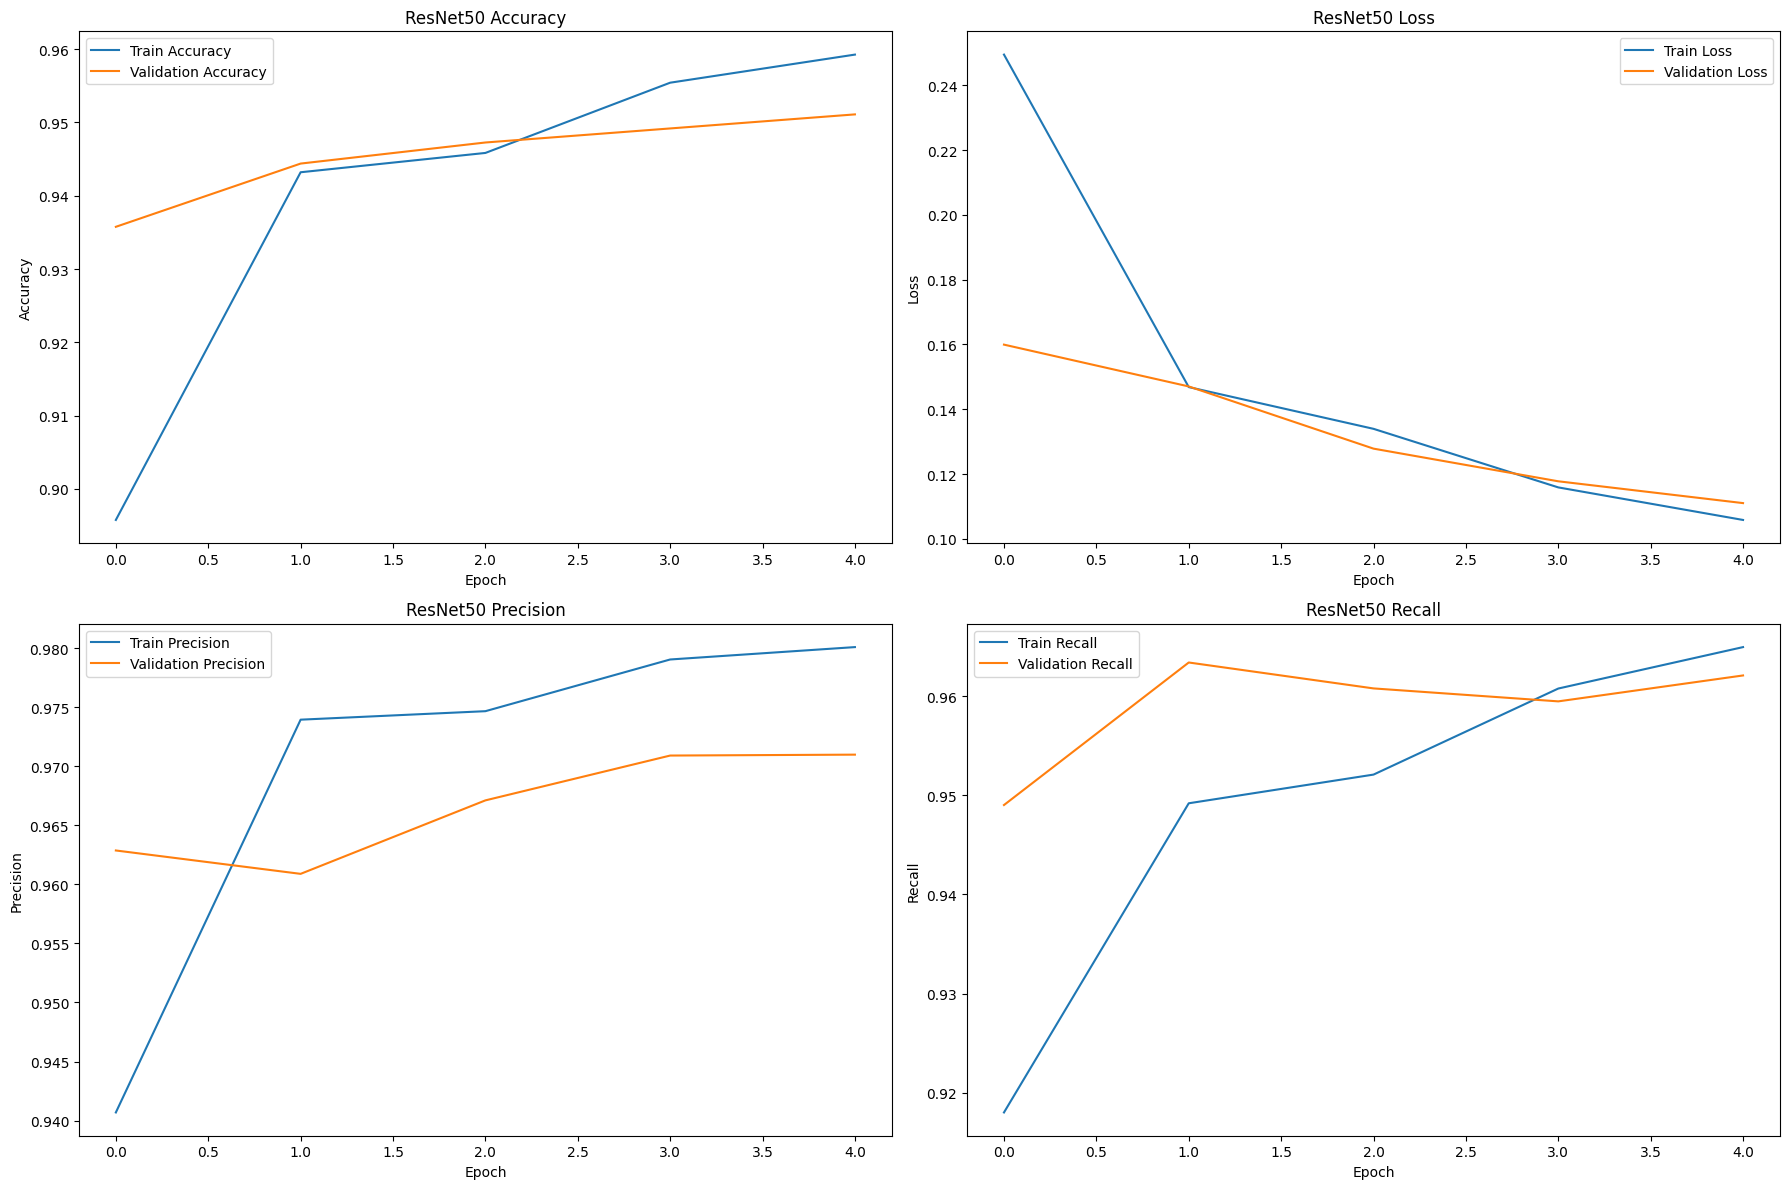

In [ ]:
plot_history(history_resnet, 'ResNet50')

In [ ]:
evaluate_model(model_resnet, train_data_resnet, 'Train')

Train Loss: 0.10250694304704666
Train Accuracy: 0.9642942547798157
Train Precision: 0.9746713638305664
Train Recall: 0.9774919748306274


In [ ]:
evaluate_model(model_resnet, val_data_resnet, 'Validation')

Validation Loss: 0.11103831976652145
Validation Accuracy: 0.951102614402771
Validation Precision: 0.9709762334823608
Validation Recall: 0.9620915055274963


In [ ]:
model_resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,593,861 (90.00 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,100 (16.02 KB)

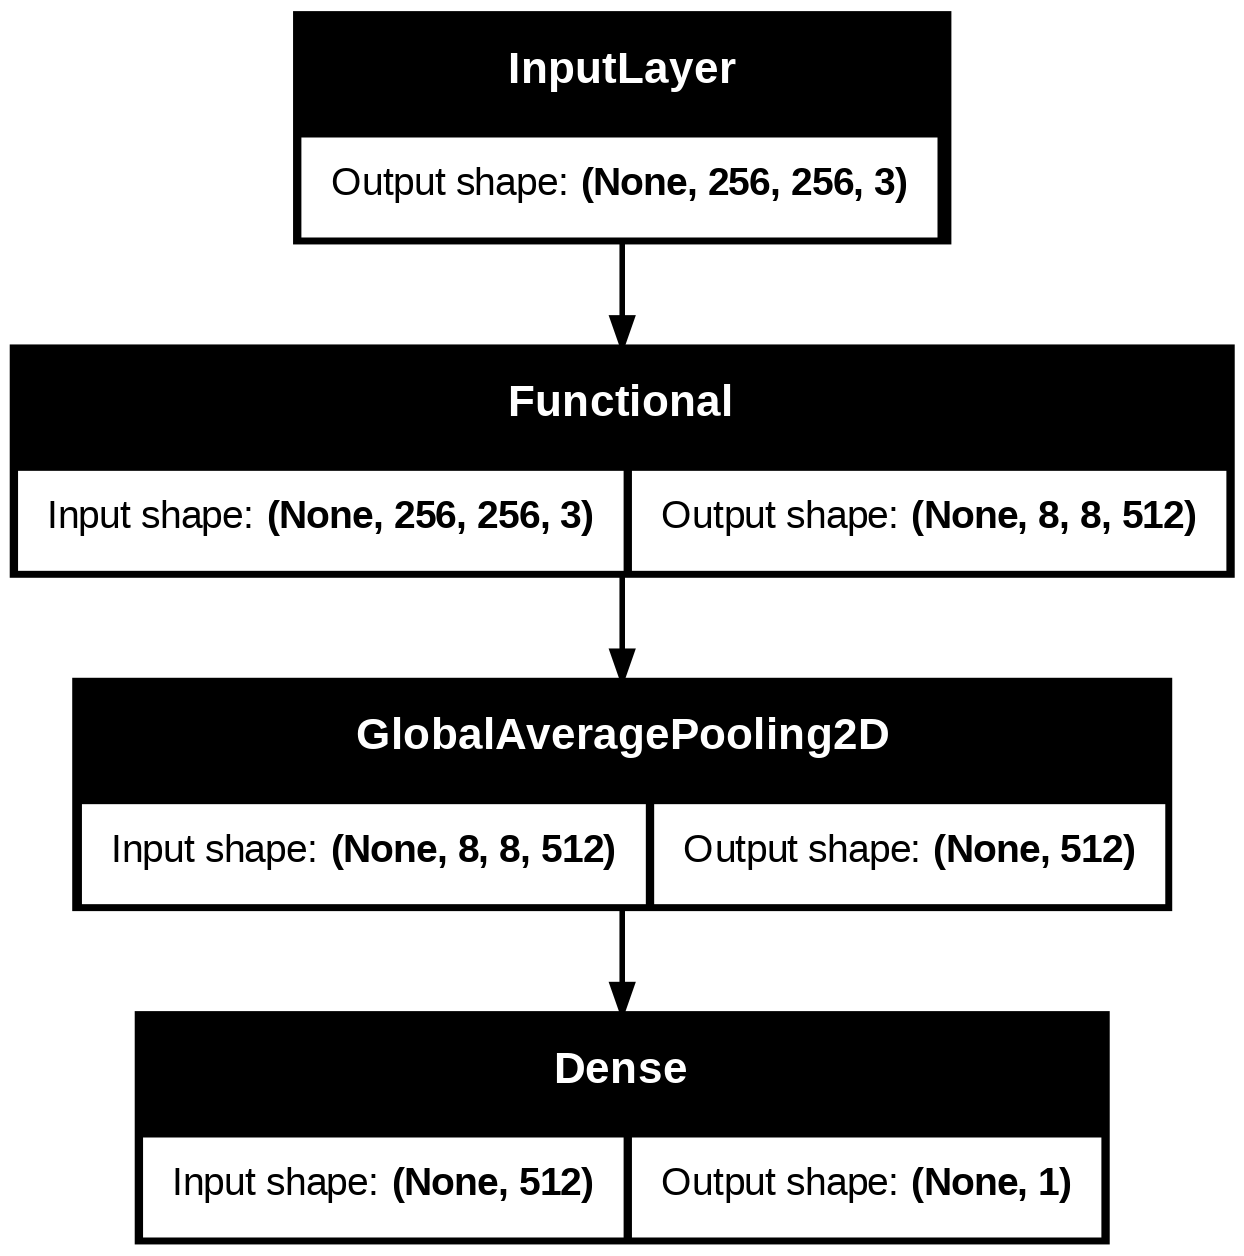

In [ ]:
tf.keras.utils.plot_model(model_vgg, show_shapes=True)

In [ ]:
from tensorflow.keras.models import load_model

model_resnet.save('/content/drive/MyDrive/SAVED MODELS/model_resnet.h5')

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/SAVED MODELS/model_resnet.h5")

In [ ]:
img_path = "/content/chest_xray/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg"
probability, prediction = predict_pneumonia(model_resnet, img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Probability: 0.9927124977111816
Predicted Class: 1


In [ ]:
img_path = "/content/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
probability, prediction = predict_pneumonia(model_resnet, img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted Probability: 0.08211953192949295
Predicted Class: 0


# **PneumoniaNet**

In [ ]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam

def PneumoniaNet():

    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.Precision(name='precision'),
                      tf.keras.metrics.Recall(name='recall')
                  ])

    return model




In [ ]:
def train_and_evaluate(model, train_dataset, val_dataset, epochs=5):
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        verbose=1)

    return history

# **Training PneumoniaNet**

In [ ]:
model = PneumoniaNet()
history_pneumonia = train_and_evaluate(model, train_data_pneumonia, val_data_pneumonia)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 136s 949ms/step - accuracy: 0.6803 - loss: 0.6434 - precision: 0.7409 - recall: 0.8812 - val_accuracy: 0.7728 - val_loss: 0.4311 - val_precision: 0.7640 - val_recall: 0.9987
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 118s 901ms/step - accuracy: 0.7996 - loss: 0.4282 - precision: 0.8226 - recall: 0.9341 - val_accuracy: 0.6874 - val_loss: 0.5837 - val_precision: 0.9955 - val_recall: 0.5765
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 145s 924ms/step - accuracy: 0.8814 - loss: 0.2809 - precision: 0.9195 - recall: 0.9220 - val_accuracy: 0.8984 - val_loss: 0.2549 - val_precision: 0.9810 - val_recall: 0.8784
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 123s 934ms/step - accuracy: 0.8939 - loss: 0.2529 - precision: 0.9294 - recall: 0.9273 - val_accuracy: 0.9319 - val_loss: 0.2014 - val_precision: 0.9639 - val_recall: 0.9425
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 120s 907ms/step - accuracy: 0.9066 - loss: 0.2405 - precision: 0.9314 - recall: 0.9439 - val_accuracy: 0.9396 - val_los

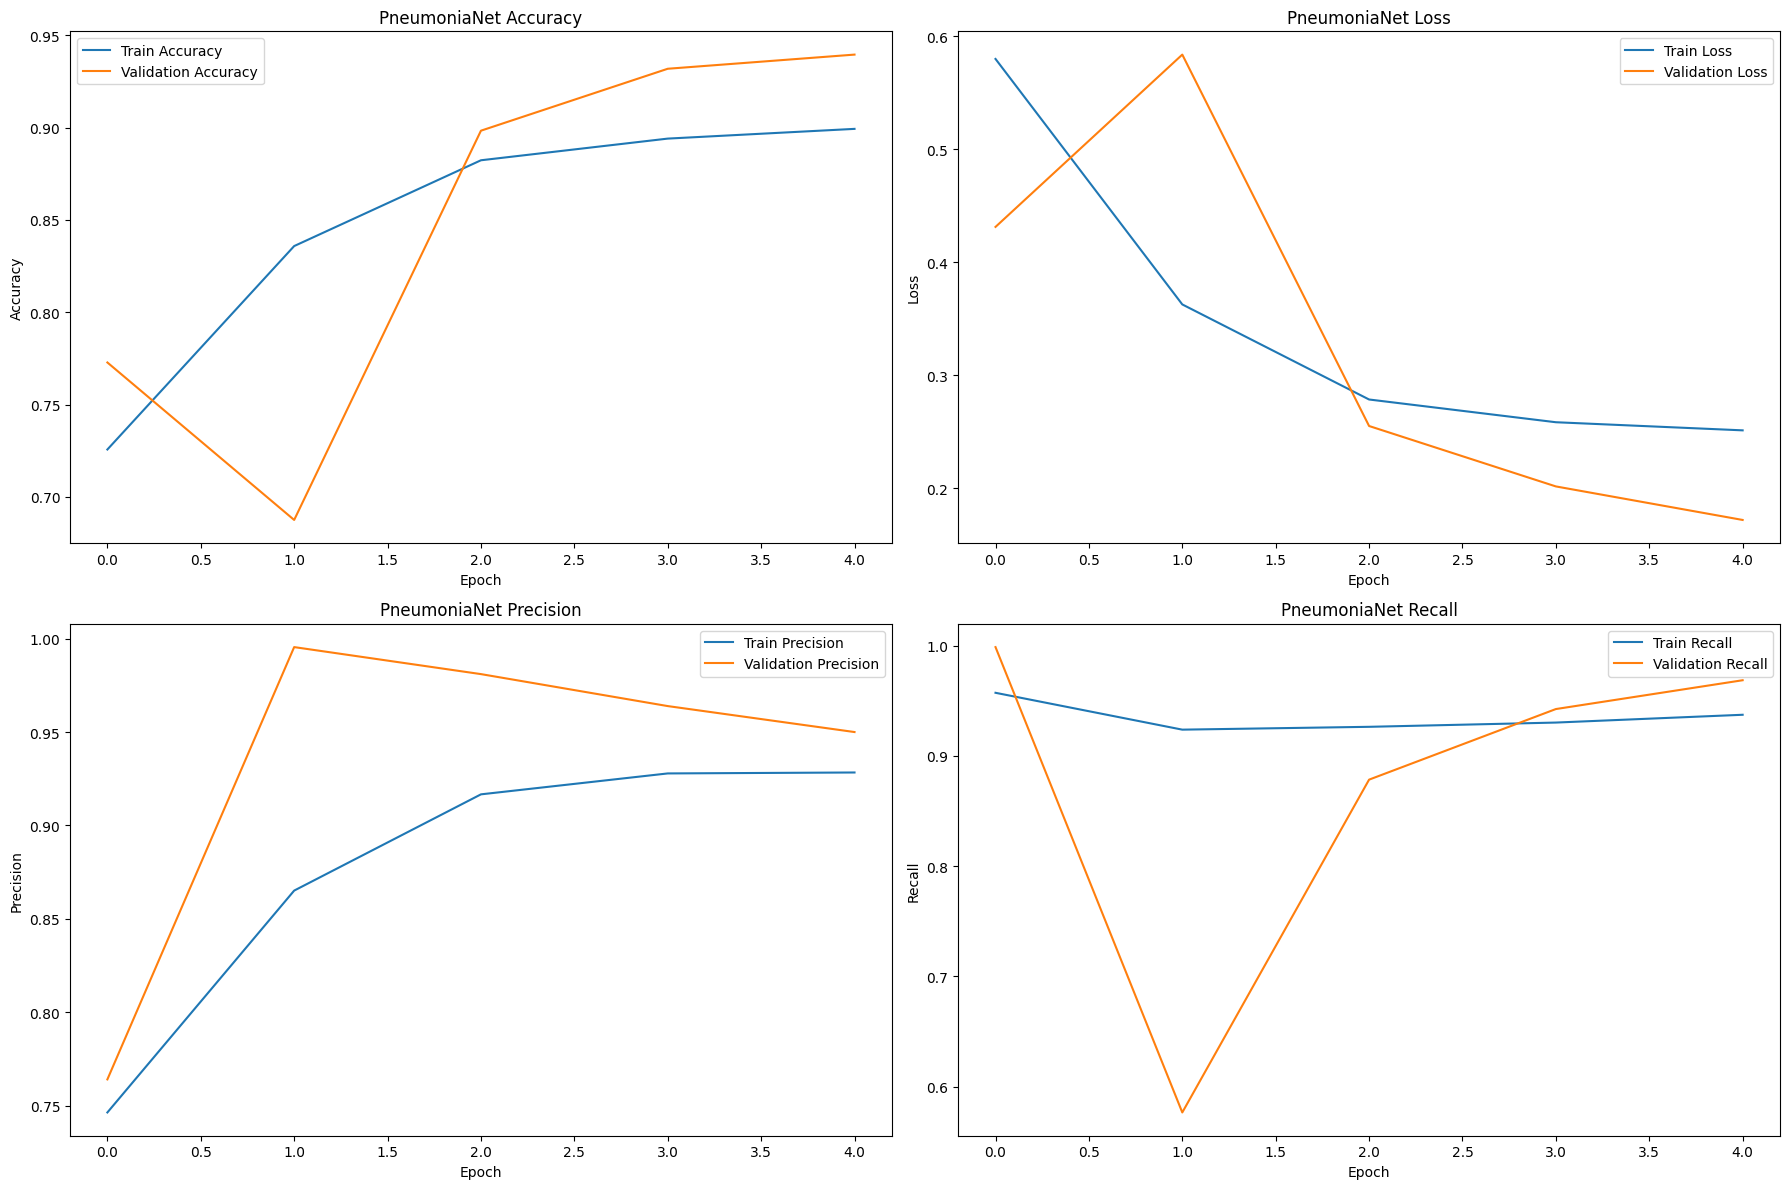

In [ ]:
plot_history(history_pneumonia, 'PneumoniaNet')

In [ ]:
evaluate_model(model, train_data_pneumonia, 'Train')

Train Loss: 0.26116693019866943
Train Accuracy: 0.8854541182518005
Train Precision: 0.8781608939170837
Train Recall: 0.9826366305351257


In [ ]:
evaluate_model(model, val_data_pneumonia, 'Validation')

Validation Loss: 0.17173893749713898
Validation Accuracy: 0.9395973086357117
Validation Precision: 0.949999988079071
Validation Recall: 0.9686274528503418


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,238,661 (298.46 MB)

 Trainable params: 26,079,553 (99.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,159,108 (198.97 MB)

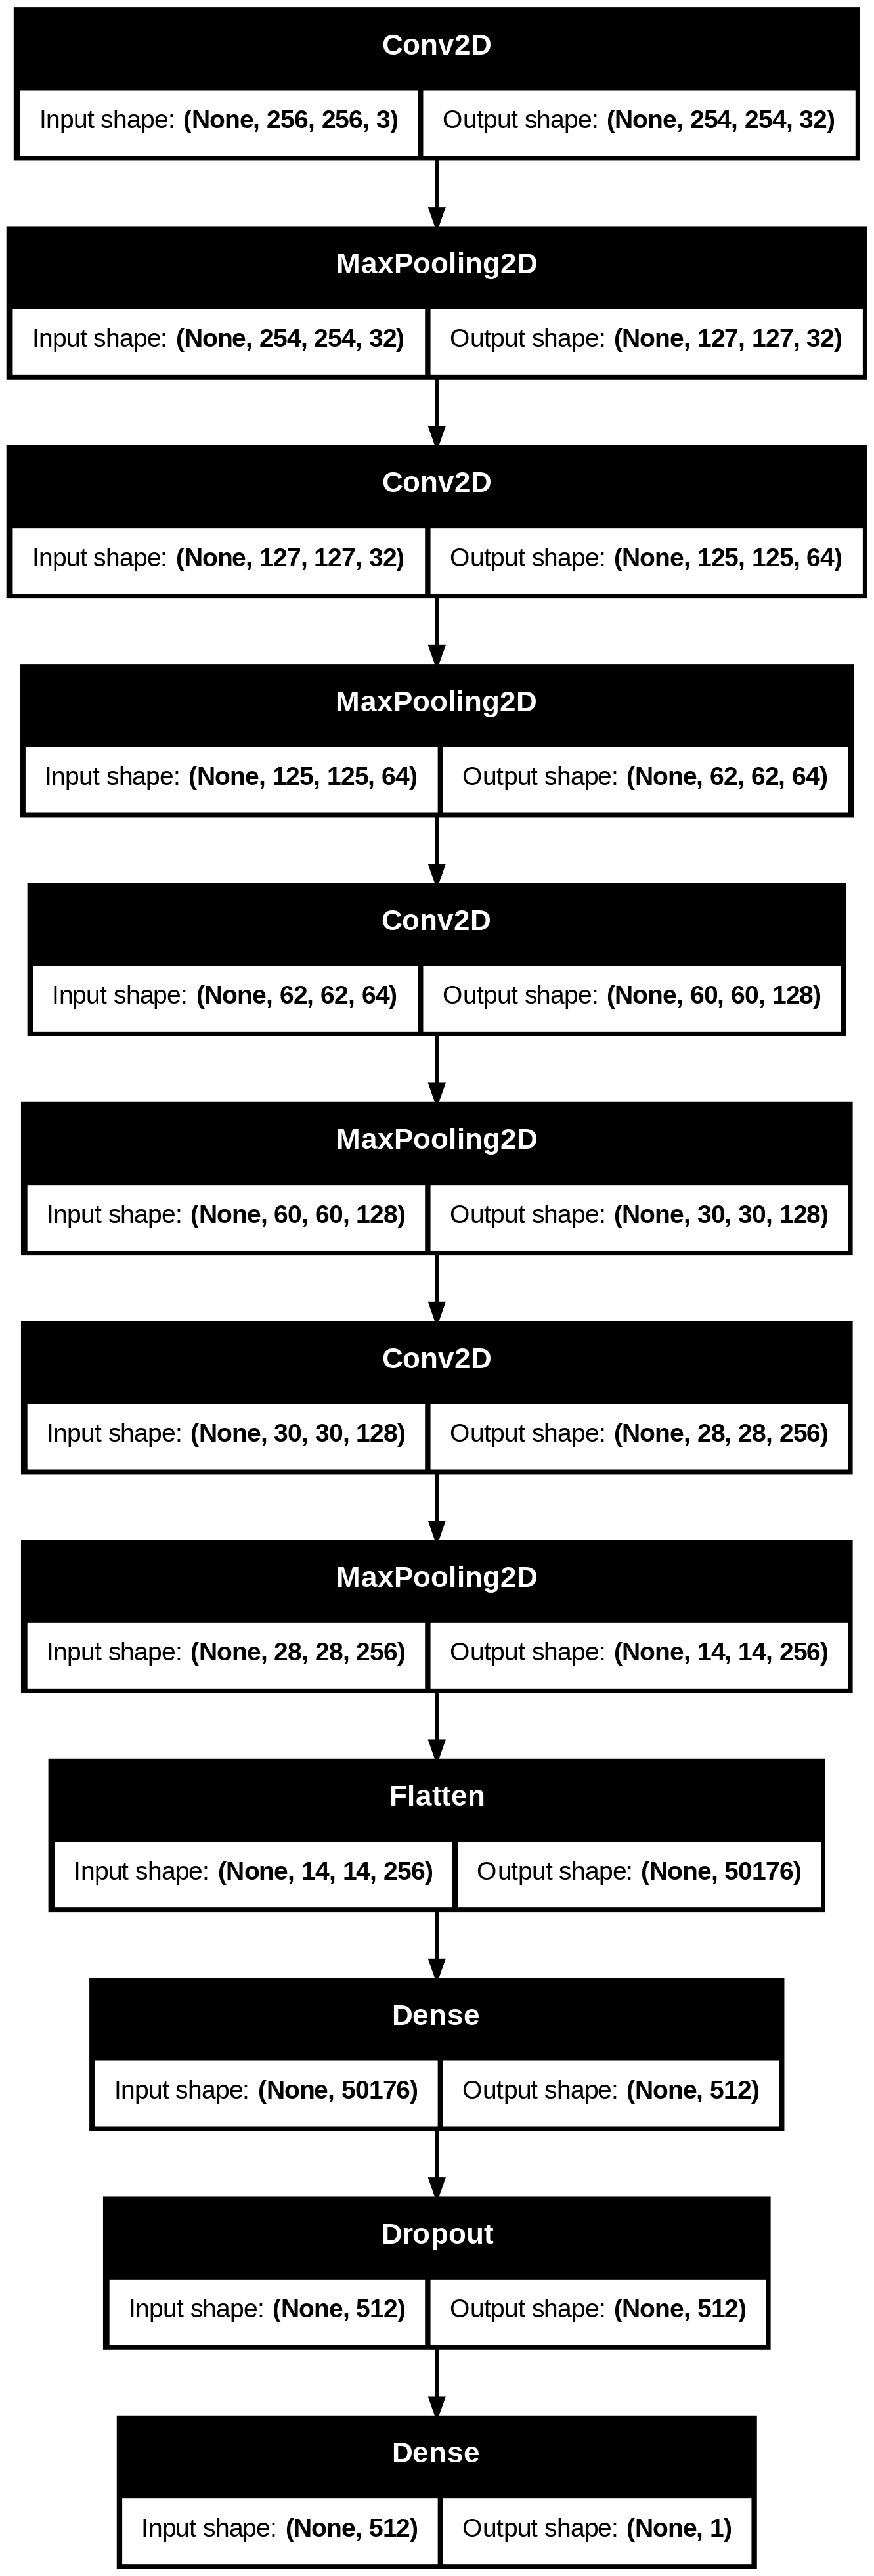

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/SAVED MODELS/model_pneumoniaNet.h5')


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/SAVED MODELS/model_pneumoniaNet.h5")

In [ ]:
img_path = "/content/chest_xray/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg"
probability, prediction = predict_pneumonia(PneumoniaNet(), img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Predicted Probability: 0.5395010709762573
Predicted Class: 1


In [ ]:
img_path = "/content/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
probability, prediction = predict_pneumonia(PneumoniaNet(), img_path)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
Predicted Probability: 0.5
Predicted Class: 0
